# Cogs 108 Final Project 
Allison Reiss, Brendan Taing, Evan Barosay, Gael Van der Lee, Daniel Benamou, Adham Rafiq

The following data analysis is centered around the following research question:

Can we distinguish the safety of different neighborhoods in San Diego based on the number of calls dispatched by the SDPD based on the degree of the call and number of dispatches, and if so, are they related to income and population?

## Import and Clean Data

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from operator import itemgetter


#load data into dataframes
beat = pd.read_csv('pd_beat_neighborhoods_datasd.csv')
call = pd.read_csv('pd_calls_for_service_2017_datasd.csv')
census = pd.read_csv('sandiegocensustract.csv')

In [2]:
# This is cleaning up the call df columns
call = call[['date_time','street','streettype','beat', 'priority']]


# This is cleaning up the census df to drop unneccessary columns
census = census.drop('TRACTNUM', axis = 1)
census = census.drop('TRACT', axis = 1)
census = census.drop('SevCrwd', axis = 1)
census = census.drop('TeenBirthAllWom', axis = 1)
census = census.drop('MaltrtAllegRate', axis = 1)
census = census.drop('ProxOffAlco', axis = 1)
census = census.drop('ProxOnAlco', axis = 1)
census = census.drop('TraffInjur', axis = 1)
census = census.drop('SNAP_FdStmp', axis = 1)
census = census.drop('n_FoodDesert', axis = 1)
census = census.drop('pct_FoodDesert', axis = 1)
census = census.drop('LiqCount', axis = 1)
census = census.drop('VoterPartic', axis = 1)
census = census.drop('HghSchOrHigh', axis = 1)
census = census.drop('Uninsured', axis = 1)
census = census.drop('PovertyPctl', axis = 1)
census = census.drop('Longitude', axis = 1)
census = census.drop('Latitude', axis = 1)
census = census.drop('LowBirthWeight', axis = 1)
census = census.drop('LowBirthWeightPctl', axis = 1)
census = census.drop('PollutionBurdenPctl', axis = 1)
census = census.drop('CES20Score', axis = 1)
census = census.drop('SingMother', axis = 1)
census = census.drop('TeenBirthProportion', axis = 1)
census = census.drop('PollutionBurdenScore', axis = 1)
census = census.drop('CES20PercentileRange', axis = 1)
census = census.drop('PopCharScore', axis = 1)
census = census.drop('PopCharPctl', axis = 1)
census = census.drop('FosterCareEntry', axis = 1)
census = census.drop('TotalPov', axis = 1)
census = census.drop('ChildPov', axis = 1)
census = census.drop('Education', axis = 1)

# change names of columns in beat dataframe to be compatible for merge
beat.columns = [
    'beat', 'neighborhood'
]

In [3]:
# Replace date_time column to include only year
call['date_time'] = call['date_time'].str[:4]
call.columns = ['year','street','streettype','beat', 'priority']

In [4]:
# Replace all 0s and 999s in beat with NaN. 
call['beat'] = call['beat'].replace(0,'NaN')
call['beat'] = call['beat'].replace(999,'NaN')

# Drop all rows with null values
call = call.dropna(how='any')

In [5]:
# Merge the call dataframe with beat dataframe to replace beat code with actual neighborhood
call = pd.merge(call, beat, on='beat')

call = call.drop(['beat'], axis=1)

## Analyze the Call dataframe and create a Heatmap to show dangerous areas

In [6]:
# Get list of unique neighborhoods in dataframe
unique_neighborhoods = call['neighborhood'].unique()

In [7]:
# This is returning a series of the neighborhoods with the most calls from greatest to least
# We might be able to show a heat map of this later
neighborhoodcalls = call['neighborhood'].value_counts()

In [8]:
# Loop through list and run algorithm on each neighborhood to get the safety level of each neighborhood
# and add it to a dict -- (neighborhood, safety level) pair

#create a dict to store the priority call sums per neighborhood
threat_lvl_dict = {}

#idx is the neighborhood name, i is the index
for idx,i in zip(call['neighborhood'],range(call['neighborhood'].size)):
    if idx in threat_lvl_dict:
        threat_lvl_dict[idx] = threat_lvl_dict[idx] + call['priority'][i]
    else:
        threat_lvl_dict[idx] = call['priority'][i]

In [9]:
# sort the dict to priority call sums in order of least to greatest
sorted_threat = sorted(threat_lvl_dict.items(), key=operator.itemgetter(1))
max_threat = max(sorted_threat,key=itemgetter(1))[1]

In [10]:
# Get the comparative percentages by dividing by highest sketchiness value to make data easier to read
for key in threat_lvl_dict:
    threat_lvl_dict[key] = (threat_lvl_dict[key] / max_threat) * 100

In [11]:
# sort the dict of percentages
threat_percents = sorted(threat_lvl_dict.items(), key=operator.itemgetter(1))

In [12]:
range = [0] * 10

#get the number of values in each percentage range
for key in threat_lvl_dict:
    slot = threat_lvl_dict[key]
    range[int((slot-.001)/10)] += 1

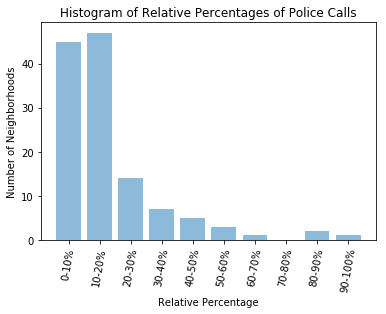

In [13]:
objects = ('0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%')
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]

plt.bar(y_pos, range, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=80)
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Relative Percentage')
plt.title('Histogram of Relative Percentages of Police Calls')
 
plt.show()

The above histogram shows the percentage distributions of threat levels of neighborhoods, when threat level is evaluated as the sum of number of calls of a given priority * priority of call. From the threat levels gathered, to normalize the data we divided each one by the maximum threat level to put them in percentiles. 

For example, if a given neighborhood has 3 priority 1 calls, 2 priority 2 calls, 0 priority 3 calls and 4 priority 4 calls, the threat level for that neighborhood would be (3*1) + (2*2) + (0*3) + (4*4) = 23. 
If the maximum threat level found was 55, we would then calculate the percentile for the given neighborhood as 23/55*100 = 41.81%

As can be seen in the histogram, a majority of neighborhoods fall on the safer side of the scale, with fewer outliers marked as more dangerous. 

In [14]:
# Google API stuff from Lecture on GEOSPATIAL ANALYTICS
# I'm currently just playing around and seeing what this kind
# of stuff does, not sure how to implement the heat map yet, this just
# gets coordinates but not sure how to encompass entire neighborhood

# simplified method using geocoder package
# https://pypi.python.org/pypi/geocoder
# pip install geocoder

import geocoder
g = geocoder.google('Pacific Beach, San Diego, CA')
g.json

{'accuracy': 'APPROXIMATE',
 'address': 'Pacific Beach, San Diego, CA, USA',
 'bbox': {'northeast': [32.823234, -117.2091551],
  'southwest': [32.7787781, -117.262754]},
 'city': 'San Diego',
 'confidence': 6,
 'country': 'US',
 'county': 'San Diego County',
 'encoding': 'utf-8',
 'lat': 32.8024577,
 'lng': -117.2355851,
 'location': 'Pacific Beach, San Diego, CA',
 'neighborhood': 'Pacific Beach',
 'ok': True,
 'place': 'ChIJ5Rm-YscB3IARbOcbiMq4vac',
 'provider': 'google',
 'quality': 'neighborhood',
 'state': 'CA',
 'status': 'OK',
 'status_code': 200}

In [15]:
g.latlng

[32.8024577, -117.2355851]

In [16]:
# upload Google API for HeatMaps

In [17]:
# import shapefile from the SDPD beats":
# http://rdw.sandag.org/Account/gisdtview?dir=Law
#
# shapefile package: pyshp
# https://pypi.python.org/pypi/pyshp
# pip install pyshp

import shapefile
sf = shapefile.Reader("SDPD_BEATS.shp")
shapes = sf.shapes()

In [18]:
shapes[0].points

[(6302781.0, 1793246.001000002),
 (6302905.0, 1793244.0),
 (6303237.538749993, 1793245.7744999975),
 (6303584.325749993, 1793240.3069999963),
 (6303667.731000006, 1793239.9897499979),
 (6303719.436499998, 1793239.919750005),
 (6303748.430500001, 1793238.7129999995),
 (6303764.414499998, 1793238.0477499962),
 (6303790.885000005, 1793236.9459999949),
 (6303846.415000007, 1792939.9539999962),
 (6303851.587750003, 1792912.3017500043),
 (6303873.0, 1792797.8340000063),
 (6303987.008000001, 1792417.048999995),
 (6304071.018999994, 1792175.1350000054),
 (6304117.781000003, 1792090.3439999968),
 (6304146.452999994, 1792038.356250003),
 (6304230.554250002, 1791885.8642500043),
 (6304258.069999993, 1791835.973000005),
 (6304309.114999995, 1791747.1459999979),
 (6304493.523000002, 1791500.425999999),
 (6304509.482250005, 1791479.0567499995),
 (6304520.040999994, 1791464.9189999998),
 (6304851.964000002, 1791056.922999993),
 (6305266.942249998, 1790555.0014999956),
 (6305275.375499994, 1790545.059

In [21]:
j=0
for i in rangelen(shapes[j].points):
    plt.scatter(shapes[j].points[i][0], shapes[j].points[i][1])

plt.show()

NameError: name 'rangelen' is not defined

## The section below will start to analyze the correlations between income and other demographic variables 

In [ ]:
# We will fill in these steps after completing the first part of our analysis (the heat maps)

In [ ]:
#looking at unique neighborhood names, probably delete later but to visualize data
print (census['NeighborhoodName'].unique().size)
census['City'].unique()